- en un embedding els punts ja no seràn els mateixos, en canvi en una projecció si. 
- relament els punts han canviat.
- quan enviem els punts cap a l'altre, agafem alguna heurística, que conservi algunes propietats de l'estructura de la distribució de punts. 
- la heurística que fa que una nn faci un embedding és la funció de loss
- ---
- els algoritmes d'embedding normalment són xarxes neuronals però també poden ser.
    - les nn són cares (dades supervidades i etiquetades)
    - quan no tenim dades etiquetades (podem fer servir altres metodologies / tipus de tecnologies) que es basen en altres heuristiques que no són la funció de loss com podría ser a la NN. 
    - Aquestes altres heurístiques són $O(n^2)$ 1M de registres, trindrem 1M·1M = $10^{12}$
        - en ML s'accepta $O(n·log(n)) - O(n)$
    - Ordre n^2 però s'accepta si no tens 10M de registres o no tens un supercomputador
- ---
- Si a part de tenir n registres, tenim moltes dimensions primer podem fer la reducció amb pca i després fem l'embedding. 
- si ja fem el primer, perquè hem de fer l'altre? 
    - Que en realitat el que volem fer es visualitzar les dades, com a molt quedar-se amb dos components o,
    - Si volem visualitzar com de llarg és el nuvol, podem fer pca i fer el scatter plot per veure la llargada i l'amplada una mica de la boira. 
    - Això pot fer que molts punts es xafin. 
- ---
- el embedding ens permet veure la estructura de les dades.
- tenen un parametre que segons com ajustem podem veure la estructura global o local.
- en el pca, només global. 
- primer projecció, intentem quedar-nos en el màxim, per no pedre molta informació.
- global i local es fer més o menys **zoom**
- dins de les galaxies pot haber-hi sub galaxies.
- ---
- les heuristiques que fan servir en mantenir la distancia de l'espai de alta dimensio i intentar representar-ho en l'espai de baixa dimensio. 
- hi han dos algoritmes d'embedding **t-SNE** t -stocastik nearest neighbour, i **UMA** unifiform manifest...
- si hi ha dos punts que estan molt junts a alta dimensio. ho intenta representar igual a baixa dimensio.
- ---
- **heuristica basica si estan junts, són més similars i s'intenta mantenir en la baixa dimensió**
- No són proporcionals, si dos punts són disimilars, han d'estar lluny.
- En comptes de fer servir el **cosine similarity**. (si els vectors que defineixen els punts apunten a la mateixa direcció). poden estar separats però ser considerats iguals. 
- Amb moltes dimensions la distancia euclidea, pot ser que no defineixi com es comporten les dades.
- si tenim una bandera de japo enrollada, no podem veure el punt, en canvi si ho fem en 2d si. Els **manifolds** no importen les dimensions. 
- ---
- necessitem calcular distancia euclidea per fer embedding? NO, perque intenta preservar similituds.

### Embedding: Fit-SNE vs. UMAP

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

#### data

In [3]:
import pickle

In [4]:
with open('../Dades/mnist_joan/mnist_784.pkl', 'rb') as pkl:
    mnist = pickle.load(pkl)

In [5]:
df = mnist.data
df.head(3)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Before the embedding it is recommendable to perform a dimensionality reduction using PCA

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

In [7]:
pca = PCA(n_components = 0.90, whiten = False)
X = pca.fit_transform(df.iloc[:, 1:561])
X.shape

(70000, 68)

#### Use cosine similarity as the similarity measure  (normalize X to be of unit length)
- L és un vector de longituds
- quan volem convertir o volem que un algoritme treballi amb cosine similarity, hem de convertir així les dades. per cada vector hem de calcular el modul. convertim la matriu de dades en una matriu de longituds. 
- Hem fet de moment: 
    - pca, reduir dims, descarrega cost computacional
    - convertir dades en una altre matriu de vectors normalitzats
    - perque funcioni amb cosine similarity, funcionarà amb distancia euclidea
    - cosine similarity, es la distancia euclidea de dos vectors que el modul és 1

In [8]:
L = np.sqrt((X**2).sum(axis=1)).reshape(-1, 1)
N = X / L
np.sum(N**2, axis = 1)

array([1., 1., 1., ..., 1., 1., 1.])

- to optimize the performance of FIt-SNE and UMAP algorithms data must be placed in continguos memory
- ---
- necessitem anar ràpid:
    - necessita que les dades de la matriu. quan carregues en memòria, la cpu busca areas de memoria buides i té una taula que li diu on són.
    - per ana ràpid els algs, et diu que les dades es carreguin en una zona junta (contigues). 
    - una matriu de numpy té flags, que indica com està. 
    - hem de fer la copia de la matriu especificant el parametre order = C, que farà ho copiarà en una area de memòria que sigui contigu. 

In [9]:
N.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

In [10]:
N = N.copy(order = 'C')

- ja tenim les dades carregades per fer el embedding.

#### Embedding with FIt-SNE

In [11]:
# pip install Cython
# conda install cython numpy fftw
# pip install fitsne
from fitsne import FItSNE

In [12]:
%%time
ppx = 30
Y_tsne = FItSNE(N, no_dims = 2, perplexity = ppx);

Will use momentum during exaggeration phase
Computing input similarities...
Using perplexity, so normalizing input data (to prevent numerical problems)
Using perplexity, not the manually set kernel width.  K (number of nearest neighbors) and sigma (bandwidth) parameters are going to be ignored.
Using ANNOY for knn search, with parameters: n_trees 50 and search_k 4500
Going to allocate memory. N: 70000, K: 90, N*K = 6300000
Building Annoy tree...
Done building tree. Beginning nearest neighbor search... 
parallel (20 threads):
CPU times: user 1min 36s, sys: 5.58 s, total: 1min 42s
Wall time: 28.1 s


- on volem fer el embedding (2 dimensions)
#### perplexity
- és una forma de especificar quin nivell d'estructura volem veure. 
- vol dir: 
- Si tenim una boira dins una bora més gran. Quan li diem perplexity 4. el que diem donat un punt, quants veins d'aquest punt volem mirar per veure que sigui similar. **Neigherhood size no ho es exactament**, però ho podem interpretar com això. 
- No mira tots els punts amb tots, sinó que en mira tots contra 4. que en reallitat ho ha de mirar tots amb tots, però ho podem pensar així. 
- es com un encadenament per anar trobant grupets. 
- com més petit més local i com més gran, més global la segmentació final.
- si fem servir petita: 
- la boira allunyada, en cap cas hem pogut agafar, perque no hem mirat en quina posició relativa està un de l'altre. 
- si en fiquem una de més gran, pot ser que els evalui i per tant intentarà preservar les similituds. 
- en comptes de sortir-ne dos, en sortirà 1 en una posició diferent. 
- perplexity petita, només ens podem creure que són boires i si són grans, ens podem creure la distribució. 
- si es petita, i surten boires pots dir una boire i l'altre són disimilars.

In [13]:
df_tsne = pd.concat((pd.DataFrame(Y_tsne, columns = ['y1', 'y2']), mnist.target), axis = 1)
df_tsne.head()

,y1,y2,class
0,5.983621,-48.615724,5
1,49.004403,-8.200610,0
2,63.194965,33.399430,4
3,-63.813492,46.993180,1
4,19.688012,18.435410,9


- Sabem cada fila que es, i l'afegim aqui per comprovar.

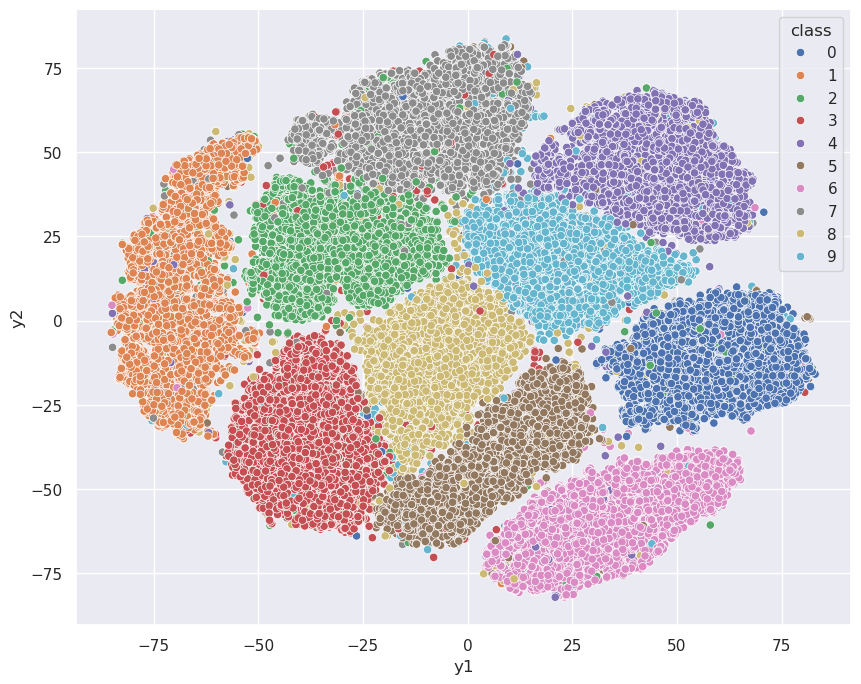

In [19]:
fig, axs = plt.subplots(1, 1, figsize = (10, 8))
sns.scatterplot(data = df_tsne, x = 'y1', y = 'y2', hue = 'class', legend = True, ax = axs);

#### Embedding with UMAP

In [15]:
# conda install umap-learn -c conda-forge
from umap import UMAP
import tqdm

In [16]:
%%time
n_neighbors = 30
Y_umap = UMAP(n_neighbors = n_neighbors, min_dist = 0.3, metric = 'correlation').fit_transform(N)

CPU times: user 4min 49s, sys: 11.2 s, total: 5min
Wall time: 32.6 s


In [17]:
df_umap = pd.concat((pd.DataFrame(Y_umap, columns = ['y1', 'y2']), mnist.target), axis = 1)
df_umap.head()

,y1,y2,class
0,3.352533,2.458153,5
1,-3.656371,0.596477,0
2,-2.621072,12.665340,4
3,13.461202,7.417502,1
4,2.266444,12.082920,9


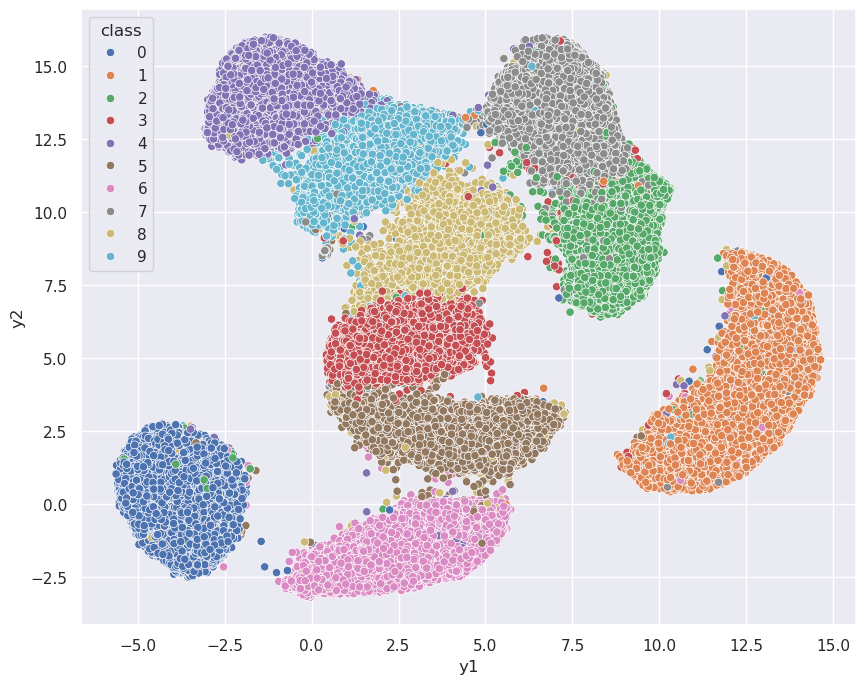

In [20]:
fig, axs = plt.subplots(1, 1, figsize = (10, 8))
sns.scatterplot(data = df_umap, x = 'y1', y = 'y2', hue = 'class', legend = True, ax = axs);

- tots els punts els tiren al dashboard al altzar, barrejats. 
- després els que s'assemblen els va apropant. 
- aqui es mouen els punts, en k-mean es mou el centroide

In [25]:
random_embedding = np.random.rand(70000, 2) *20 -5
random_embedding

array([[ 2.47657993,  8.64066435],
       [-0.05204582,  7.94970002],
       [10.1414575 , 14.88035164],
       ...,
       [ 0.32609746, 13.87879106],
       [-2.2215871 ,  8.1707057 ],
       [-3.12075829, 12.82970834]])

In [26]:
df_rand = pd.concat((pd.DataFrame(random_embedding, columns = ['y1', 'y2']), mnist.target), axis = 1)
df_rand.head()

,y1,y2,class
0,2.476580,8.640664,5
1,-0.052046,7.949700,0
2,10.141458,14.880352,4
3,-2.359298,11.616972,1
4,4.742966,7.532822,9


#### Així comença l'algoritme

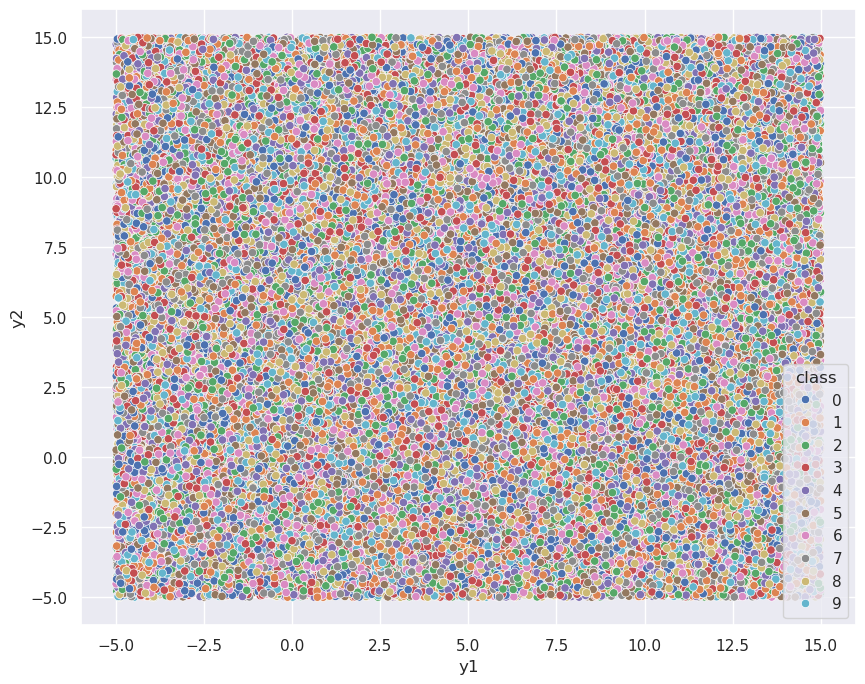

In [27]:
fig, axs = plt.subplots(1, 1, figsize = (10, 8))
sns.scatterplot(data = df_rand, x = 'y1', y = 'y2', hue = 'class', legend = True, ax = axs);

- Diu: els vermells, els comença a ajuntar.
- Per fer-ho: heuristica, les distancies s'assemblin a les del espai d'alta dimensionalitat
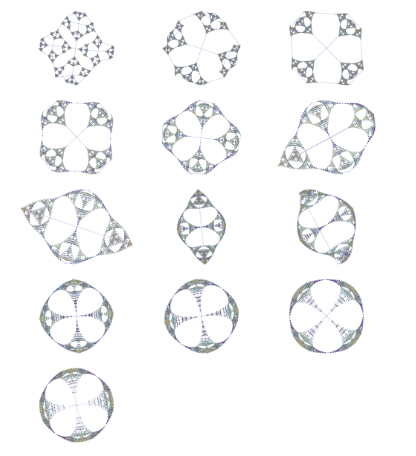

#### triangulo de sierpinski